In [7]:
import numpy as np
text = "You say goodbye and I say hello."

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    

    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [8]:
corpus, word_to_id, id_to_word = preprocess(text)

In [9]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [10]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]
    one_hot = np.zeros((N, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        one_hot[idx, word_id] = 1
    
    return one_hot

In [11]:
convert_one_hot(corpus, 7)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [12]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    for idx, word_idx in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_idx = corpus[left_idx]
                co_matrix[word_idx, left_word_idx] += 1
                
            if right_idx < corpus_size:
                right_word_idx = corpus[right_idx]
                co_matrix[word_idx, right_word_idx] +=1
        
    return co_matrix

In [13]:
m = create_co_matrix(list(corpus), 7)

In [14]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) +  eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

In [15]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.707106769115


In [16]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    print('[query]'  + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s:  %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [17]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)

[query]you
 goodbye:  0.707106769115
 i:  0.707106769115
 hello:  0.707106769115
 say:  0.0
 and:  0.0


In [18]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total //100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [19]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print(C)
print('-'*50)
print(W)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
[[ 0.     1.807  0.     0.     0.     0.     0.   ]
 [ 1.807  0.     0.807  0.     0.807  0.807  0.   ]
 [ 0.     0.807  0.     1.807  0.     0.     0.   ]
 [ 0.     0.     1.807  0.     1.807  0.     0.   ]
 [ 0.     0.807  0.     1.807  0.     0.     0.   ]
 [ 0.     0.807  0.     0.     0.     0.     2.807]
 [ 0.     0.     0.     0.     0.     2.807  0.   ]]


In [20]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

U, S, V = np.linalg.svd(W)

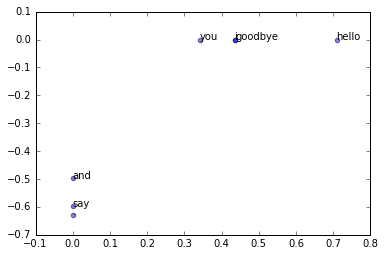

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()